# Support vector classifier optimisation: PEGASOS

In this notebook, we implement the kernelized Primal Estimated sub-GrAdient SOlver for SVM (PEGASOS) algorithm to solve a non-linear classification problem using a support vector classifier. The implementation is based on the original [Pegasos paper](https://doi.org/10.1007/s10107-010-0420-4).

To test the implementation, we will use the moons dataset from Scikit-Learn. As there are only two features, it will be easy to visualise the resulting decision boundary. Let's first import the libraries that we will need and generate the dataset. Features scaling is applied to the dataset so that features have a mean of 0 and a standard deviation of 1. Also, the class label 0 is replaced by -1 as it is the norm for support vector classifiers. 

As the purpose of this notebook is to implement the optimisation algorithm, we do not split the dataset into a training set and a test set. 

In [1]:
import numpy as np
from random import randint
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

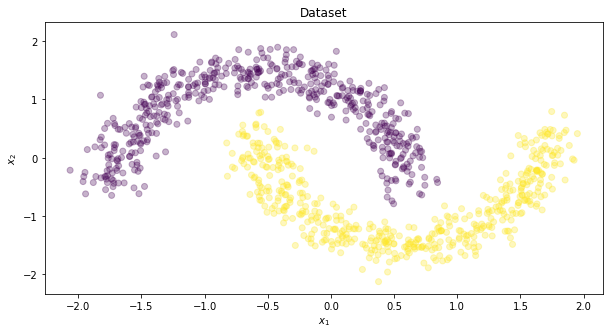

In [2]:
# Dataset creation
X, y = make_moons(n_samples=1000, noise=0.1, random_state=1)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X, y)
y[y == 0] = -1

# Plot the dataset
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(X_scaled[:,0], X_scaled[:,1], c=y, alpha=0.3)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Dataset');

# Implementation

For an introduction to support vector classifiers, please see the SMO notebook. PEGASOS is used to solve the primal problem. The implementation is based on the original paper.

In [3]:
# Kernelized pegasos algorithm based on the original paper
def kernelized_pegasos(x, y, kernel, T, lam):
    N = len(y)
    alphas = np.zeros(N)
    alphas_info = alphas
    for t in range(T):
        i = randint(0, N-1)
        check = 0
        for j in range(N):
            check += alphas[j] * y[i] * kernel(x[i], x[j])
        check *= y[i]/lam*t
        if check < 1:
            alphas[i] += 1
        alphas_info = np.vstack((alphas_info, alphas))
    return alphas, alphas_info

We create a function for the Gaussian kernel.

In [4]:
def gaussian_kernel(x, y, sigma=1):
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        return np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        return np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        return np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))

We create a function to predict the labels.

In [5]:
def classify_func(alphas, y, kernel, X, x_test, b):
    return (alphas * y) @ kernel(X, x_test) + b

Finally we create a function to plot the decision boundary.

In [6]:
def plot_decision_boundary(alphas, X, y, b, kernel, ax):
    
    # Evaluate model over 100x100 grid
    xrange = np.linspace((X[:,0].min())*1.05, (X[:,0].max())*1.05, 100)
    yrange = np.linspace((X[:,1].min())*1.05, (X[:,1].max())*1.05, 100)
    grid = [[classify_func(alphas, y,kernel, X, np.array([xr, yr]), b) for xr in xrange] for yr in yrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))
    
    # Plot the classify function contours using the grid
    ax.contour(xrange, yrange, grid, levels=(-1, 0, 1), linewidths=(1, 1, 1), 
               linestyles=('--', '-', '--'), colors=('b', 'k', 'r'))
    # Scatter plot of the dataset
    ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.viridis, lw=0, alpha=0.3)
    
    # Plot support vectors (circled)
    non_zero_alpha = np.round(alphas, decimals=2) != 0.0
    ax.scatter(X[non_zero_alpha, 0], X[non_zero_alpha, 1], c=y[non_zero_alpha], 
               cmap=plt.cm.viridis, lw=1, edgecolors='k')
    
    return grid, ax

# Testing the algorithm

First, let's initialise the hyperparameters. The hyperparameters $\lambda$ and $\sigma$ could be found using optimisation techniques but this is not the purpose of this notebook. 

In [7]:
X = X_scaled

# Parameters
T = 400 # Number of iterations
lam = 500 # Regularisation parameter (lambda)
sigma = 0.2 # Standard deviation used in Gaussian Kernel

Let's train the model and print the training time.

In [8]:
# Model training
time_start = time.time()
alphas, alphas_info = kernelized_pegasos(X, y, lambda i, j: gaussian_kernel(i, j, sigma=sigma), T=T, lam=lam)
time_end = time.time()

print("The model was trained in " + str(round(time_end - time_start, 2)) + " seconds.")

The model was trained in 3.8 seconds.


Let's plot the decision boundary.

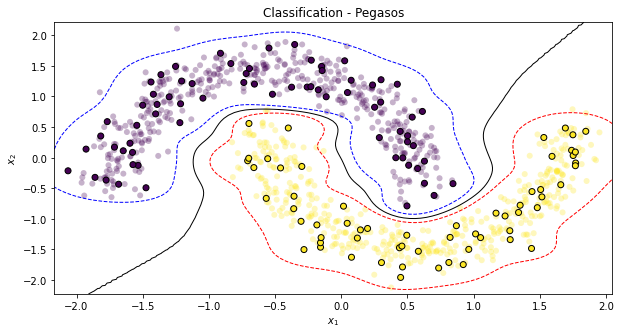

In [9]:
# Plot the decision boundary on the scatter plot
fig, ax = plt.subplots(figsize=(10,5))
grid, ax = plot_decision_boundary(alphas, X, y, 0, lambda i, j: gaussian_kernel(i, j, sigma=sigma), ax)
ax.set_title('Classification - Pegasos')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$');

We also plot the confusion matrix which shows the classification result.

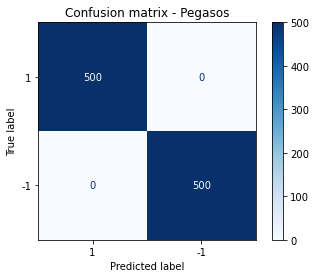

In [10]:
# Predict the class label for each sample
pred = []
for k in range(len(y)):
    check = classify_func(alphas, y, lambda i, j: gaussian_kernel(i, j, sigma=sigma), 
                          X, np.array([X[k,0], X[k,1]]), 0)
    pred.append(np.sign(check))

# Create the confusion matrix
cm = confusion_matrix(y, pred)

# Plot the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
disp = disp.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion matrix - Pegasos');

# Convergence

Finally, we can analyse the convergence of the algorithm by plotting the Q-convergence. It is done by plotting

\begin{equation}
    \frac{\lVert \alpha_{t + 1} - \alpha^* \rVert}{\lVert \alpha_t - \alpha^* \rVert}
\end{equation}

where $\alpha_t$ is the $\alpha$ vector at iteration $t$ and $\alpha^*$ is the optimal $\alpha$ vector (i.e. the one to which the algorithm has converged).

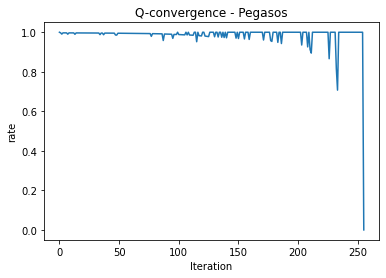

In [11]:
# Compute the norm of the difference between alpha_t and alpha*
c = []
for i in range(len(alphas_info)):
    c.append(np.linalg.norm(alphas_info[i] - alphas_info[-1]))

c = np.array(c)

# Q-convergence plot    
fig = plt.figure()
ax = fig.add_subplot(111)
with np.errstate(invalid='ignore'):
    ax.plot(np.divide(c[1:], c[0:-1]))
ax.set_xlabel('Iteration')
ax.set_ylabel('rate')
ax.set_title('Q-convergence - Pegasos');

We can also investigate the exponential convergence plot by plotting

\begin{equation}
    \ln \left( \lVert \alpha_t - \alpha^* \rVert \right)
\end{equation}

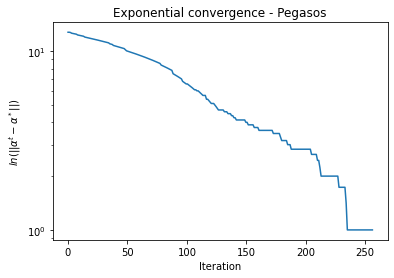

In [12]:
# Plot of the exponential convergence
fig = plt.figure()
ax = fig.add_subplot(111)
stop = np.where(c==0.)[0][0]
ax.semilogy(np.linspace(0, stop, stop), c[:stop])
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$ln(||\alpha^t - \alpha^*||)$')
ax.set_title('Exponential convergence - Pegasos'); 